# Part 0 - Intro

In [150]:
# Set number of GPUs
# num_gpus = 4   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (256, 256)  #Default to (256,256), use (None,None) if you do not want to resize imgs

In [151]:
# Import all the necessary libraries
import os
import datetime
import glob
import random
import re
import sys
import time
import zipfile

import tqdm

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from PIL import Image, ImageDraw

import dask.array as da
import h5py
import numpy as np

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda, AlphaDropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.utils import multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras import backend as K

import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

import ogr
import gdal
from osgeo import gdal_array

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
tf.test.gpu_device_name()

Python       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
Numpy        : 1.19.5
Skimage      : 0.18.3
Scikit-learn : 1.0.1
Keras        : 2.7.0
Tensorflow   : 2.7.0


'/device:GPU:0'

In [152]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

# Part 1 - Data Input

In [153]:
# https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
# https://gis.stackexchange.com/questions/16837/how-can-i-turn-a-shapefile-into-a-mask-and-calculate-the-mean
def vectorPoly_to_rasterMask(vector, raster, suffix='_mask', output=None, show=False):
    """
    Function to turn a vector Polygon (ogr) into a raster binary mask (gdal) of 1 for present, 0 for absent
    
    Outputs a raster geotiff with extents according to the input raster.
    """
    if output==None:
        output = raster.split('.')[0]+suffix+"."+raster.split('.')[-1]
    
    
    ## Open raster data source
    assert(os.path.exists(raster))
    raster_ds = gdal.Open(raster)
    raster_prj = raster_ds.GetProjection()
    
    ulx, px, rx, uly, ry, py = raster_ds.GetGeoTransform()  #upper left X, pixel resolution X, rotation X, upper left Y, pixel resolution Y, rotation Y
    px, py = round(px,2), round(py,2)  #round pixel size to two decimal places
    width, height = raster_ds.RasterXSize, raster_ds.RasterYSize  #number of x columns and number of y rows
    #print(ulx, px, rx, uly, ry, py), (width, height)
    '''

      ul-------ur
    ^  |       |
    |  |  geo  |    y increases going up, x increases going right
    y  |       |
      ll-------lr
          x-->

    '''
    assert(rx==0 and ry==0)   #assuming zero rotation!!
    llx = ulx
    lly = uly + (height * py)
    urx = ulx + (width * px)
    ury = uly
    bbox = (llx, lly, urx, ury)  #minx, miny, maxx, maxy
    #print("min_xy:({0},{1}), max_xy:({2},{3})".format(*bbox))
    
    
    ## Open vector data source
    assert(os.path.exists(vector))
    vector_ds = ogr.Open(vector)
    vector_lyr = vector_ds.GetLayer()
    vector_prj = vector_lyr.GetSpatialRef()
    vector_ext = vector_lyr.GetExtent()   #x_min, x_max, y_min, y_max
    #print(vector_ext)
    
    
    ## Create the raster mask according to input raster dimensions
    #print((urx - llx) / px, (ury - lly) / abs(py))
    x_res = int(round((urx - llx) / px, 0))
    y_res = int(round((ury - lly) / abs(py), 0))  #turn negative pixel size y to absolute value
    #print(x_res, y_res)
    target_ds = gdal.GetDriverByName('GTiff').Create(output, x_res, y_res, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform((llx, px, rx, uly, ry, py))
    target_ds.SetProjection(raster_prj)
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(np.nan)
    
    ## Rasterize
    err = gdal.RasterizeLayer(target_ds, [1], vector_lyr, None, None, [1], ['ALL_TOUCHED=TRUE'])
    target_ds.FlushCache()
    
    
    ## Create output arrays
    img_ary = np.dstack([raster_ds.GetRasterBand(i).ReadAsArray() for i in range(1,4)])
    msk_ary = target_ds.GetRasterBand(1).ReadAsArray()
   
    
    ## Visualize the raster with its output mask
    if show==True:
        #f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        skimage.io.imshow(img_ary)
        plt.show()
        skimage.io.imshow(msk_ary)
        plt.show()
        #skimage.io.imsave(output, mask_ary)
    
    ## Final checks and turn mask into boolean array
    #print(img_ary.shape[:2], msk_ary.shape)
    assert(img_ary.shape[:2]==msk_ary.shape)   #check that shape of image and mask are the same
    msk_ary = skimage.transform.resize(msk_ary, output_shape=msk_ary.shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
    msk_ary = msk_ary.astype(bool)  #convert to binary mask of either 0 or 1
    
    return img_ary, msk_ary

def ary_to_tiles(ary, shape=(256,256), exclude_empty=False):
    """
    Function to turn a big 2D numpy array (image) and tile it into a set number of shapes
    
    Outputs a stacked numpy array suitable for input into a Convolutional Neural Network
    """
    assert(isinstance(ary, np.ndarray))
    assert(isinstance(shape, tuple))
    
    ary_height, ary_width = shape
    ary_list = []
    
    total = 0
    excluded = 0
    for x_step in range(0, ary.shape[1], ary_width):
        for y_step in range(0, ary.shape[0], ary_height):
            x0, x1 = x_step, x_step+ary_width
            y0, y1 = y_step, y_step+ary_height
            
            crop_ary = ary[y0:y1, x0:x1]
            try:
                total += 1
                assert(crop_ary.shape == (ary_height, ary_width, ary.shape[2]))  #do not include images not matching the intended size
            except AssertionError:
                excluded += 1
                #print(y0,y1,x0,x1, 'excluded')
                continue
            ary_list.append(crop_ary)
    
    if excluded > 0:
        print("INFO: {0}/{1} tiles were excluded due to not fitting shape {2}".format(excluded, total, shape))
    return np.stack(ary_list), excluded

splitName = lambda filename: filename.split(os.sep)[-1].split('.')[0]   #function to strip filename of its directories and extension

## Visualize masks on the training data

# Part 2 - Build model

In [154]:
# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.50, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score) 
        return K.mean(K.stack(prec), axis=0)

In [155]:
# Design our model architecture here
def keras_model(img_width=256, img_height=256, tensorboard_images=False):
    '''
    Modified from https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/
    Architecture inspired by https://blog.deepsense.ai/deep-learning-for-satellite-imagery-via-image-segmentation/
    '''
    #n_ch_exps = [4, 5, 6, 7, 8]   #the n-th deep channel's exponent i.e. 2**n 16,32,64,128,256
    n_ch_exps = [6, 6, 6, 6, 6]
    k_size = (3, 3)                     #size of filter kernel
    k_init = 'lecun_normal'             #kernel initializer
    activation = 'selu'

    if K.image_data_format() == 'channels_first':
        ch_axis = 1
        input_shape = (3, img_width, img_height)
    elif K.image_data_format() == 'channels_last':
        ch_axis = 3
        input_shape = (img_width, img_height, 3)

    inp = Input(shape=input_shape)
    if tensorboard_images == True:
        tf.summary.image(name='input', tensor=inp)
    encodeds = []

    # encoder
    enc = inp
    print(n_ch_exps)
    for l_idx, n_ch in enumerate(n_ch_exps):
        with K.name_scope('Encode_block_'+str(l_idx)):
            enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation=activation, padding='same', kernel_initializer=k_init)(enc)
            enc = AlphaDropout(0.1*l_idx,)(enc)
            enc = Conv2D(filters=2**n_ch, kernel_size=k_size, dilation_rate=(2,2), activation=activation, padding='same', kernel_initializer=k_init)(enc)
            encodeds.append(enc)
            #print(l_idx, enc)
            if l_idx < len(n_ch_exps)-1:  #do not run max pooling on the last encoding/downsampling step
                enc = MaxPooling2D(pool_size=(2,2))(enc)  #strides = pool_size if strides is not set
                #enc = Conv2D(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation=activation, padding='same', kernel_initializer=k_init)(enc)
            if tensorboard_images == True:
                tf.summary.histogram("conv_encoder", enc)
            
    # decoder
    dec = enc
    print(n_ch_exps[::-1][1:])
    decoder_n_chs = n_ch_exps[::-1][1:]
    for l_idx, n_ch in enumerate(decoder_n_chs):
        with K.name_scope('Decode_block_'+str(l_idx)):
            l_idx_rev = len(n_ch_exps) - l_idx - 1  #
            dec = concatenate([dec, encodeds[l_idx_rev]], axis=ch_axis)
            dec = Conv2D(filters=2**n_ch, kernel_size=k_size, dilation_rate=(2,2), activation=activation, padding='same', kernel_initializer=k_init)(dec)
            dec = AlphaDropout(0.1*l_idx)(dec)
            dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation=activation, padding='same', kernel_initializer=k_init)(dec)
            dec = Conv2DTranspose(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation=activation, padding='same', kernel_initializer=k_init)(dec)

    outp = Conv2DTranspose(filters=1, kernel_size=k_size, activation='sigmoid', padding='same', kernel_initializer='glorot_normal')(dec)
    if tensorboard_images == True:
        tf.summary.image(name='output', tensor=outp)
    
    model = Model(inputs=[inp], outputs=[outp])
    
    return model

In [156]:
# Set some model compile parameters
#optimizer = keras.optimizers.Adam()
optimizer = tf.keras.optimizers.Adam()
loss      = 'binary_crossentropy'
metrics   = [mean_iou]

# Compile our model
model = keras_model(img_width=img_width, img_height=img_height)
model.summary()

# For more GPUs
#if num_gpus > 1:
#    model = multi_gpu_model(model, gpus=num_gpus)
    
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[6, 6, 6, 6, 6]
[6, 6, 6, 6]
Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_372 (Conv2D)            (None, 256, 256, 64  1792        ['input_22[0][0]']               
                                )                                                                 
                                                                                                  
 alpha_dropout_186 (AlphaDropou  (None, 256, 256, 64  0          ['conv2d_372[0][0]']             
 t)                             )                             

# Part 3 - Run model

# Part 4 - Evaluate output

In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
# Reload the model
model_loaded = keras_model(img_width=img_width, img_height=img_height)
model_loaded.load_weights("/content/drive/MyDrive/ChangeDetection/model-weights.hdf5")
model_loaded.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[6, 6, 6, 6, 6]
[6, 6, 6, 6]


## Visualize predictions on the cross-validation test data

## Visualize predictions on the training data

## Visualize predictions on the new data!!

In [159]:
def ary_to_tiles(ary, shape=(256,256), exclude_empty=False):
    """
    Function to turn a big 2D numpy array (image) and tile it into a set number of shapes
    
    Outputs a stacked numpy array suitable for input into a Convolutional Neural Network
    """
    assert(isinstance(ary, np.ndarray))
    assert(isinstance(shape, tuple))
    
    ary_height, ary_width = shape
    ary_list = []
    coor_list = []
    
    total = 0
    excluded = 0
    for x_step in range(0, ary.shape[1], ary_width):
        for y_step in range(0, ary.shape[0], ary_height):
          #print("ary_width",ary_width,"ary_height",ary_height)
          
          
          x0, x1 = x_step, x_step+ary_width
          y0, y1 = y_step, y_step+ary_height
          
          crop_ary = ary[y0:y1, x0:x1]
          try:
              total += 1
              assert(crop_ary.shape == (ary_height, ary_width, ary.shape[2]))  #do not include images not matching the intended size
          except AssertionError:
              excluded += 1
              #print(y0,y1,x0,x1, 'excluded')
              
              continue
          ary_list.append(crop_ary)
          coor_list.append((x_step,y_step))
          
    
    if excluded > 0:
        print("INFO: {0}/{1} tiles were excluded due to not fitting shape {2}".format(excluded, total, shape))
    return np.stack(ary_list), excluded, coor_list

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f92e40073f0> >
INFO: 8/18 tiles were excluded due to not fitting shape (256, 256)
(10, 256, 256, 3)
<class 'list'> [(0, 0), (0, 256), (256, 0), (256, 256), (512, 0), (512, 256), (768, 0), (768, 256), (1024, 0), (1024, 256)]
1/1 [==============================] - 0s 30ms/step
(10, 256, 256, 1) float32
<class 'numpy.ndarray'>
(512, 1280)


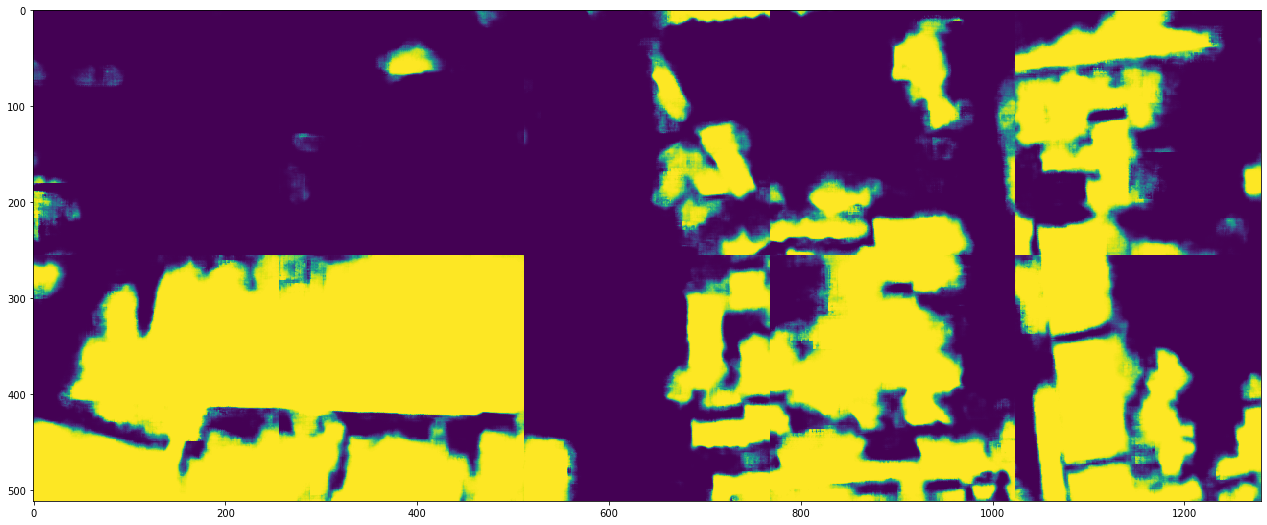

In [171]:
# Load raster data into numpy array
#ds = gdal.Open('test/wellington-03m-rural-aerial-photos-2012-2013.tif') #get from https://data.linz.govt.nz/layer/51870-wellington-03m-rural-aerial-photos-2012-2013/   
#filename = "/content/drive/MyDrive/ChangeDetection/source/After-Google_AOI_03.tif"
#filename = "/content/drive/MyDrive/ChangeDetection/source/After-ESRI_AOI_03.tif"
filename = "/content/drive/MyDrive/ChangeDetection/source/Before_Bing_AOI_03.tif"
#filename = "/content/drive/MyDrive/ChangeDetection/source/After_ESRI.tif"

ds = gdal.Open(filename)
print(ds)
ary = np.dstack([ds.GetRasterBand(i).ReadAsArray() for i in range(1,4)])
W_test, ex, coor = ary_to_tiles(ary, shape=(img_height, img_width))
print(W_test.shape)
print(type(coor),coor)

W_hat_test = model_loaded.predict(W_test, verbose=1)
print(W_hat_test.shape, W_hat_test.dtype)
print(type(W_hat_test))

output = np.array([[0 for x in range(coor[-1][0]+img_height)] for y in range(coor[-1][1]+img_width)]).astype(float)
print(output.shape)

ii = 0
for i in coor:
  #print("i ",i)
  #print("i[1]=",i[1]," : img_height=", i[1] + img_height, ",", "i[0]=",i[0]," : img_width=",i[0]+img_width)
  #print(W_hat_test[ii][:,:,0].shape)
  np.copyto(output[i[1] : i[1]+img_height , i[0] : i[0]+img_width], W_hat_test[ii][:,:,0])
  ii = ii + 1
  #if i[1] == 256:
  #  break
  
  
#for i in range(0,len(W_test)):
#  W_hat_test[i][:,:,0]
#plt.figure(figsize = (16,12))
#plt.imshow(output)

#px = 1/plt.rcParams['figure.dpi']  # pixel in inches
#plt.subplots(figsize=(1024*px, 512*px))
plt.figure(figsize = (22,32))
plt.imshow(output, interpolation='nearest')
#plt.text(0.5, 0.5, '600px x 200px', **text_kwargs)
#plt.show()

In [161]:
'''try:
    for id in range(0,len(W_test)): 
      #print(type(W_test[id]))
      #print(id, W_test[id].shape)
      fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(20,20))
      axarr[0, 0].imshow(W_test[id])
      axarr[0, 1].imshow(W_hat_test[id][:,:,0])
      #plt.show()
      saveFile = '/content/drive/MyDrive/ChangeDetection/output1/after-'+str(id)+'.png'
      plt.savefig(saveFile)
except TypeError:
  pass'''

"try:\n    for id in range(0,len(W_test)): \n      #print(type(W_test[id]))\n      #print(id, W_test[id].shape)\n      fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(20,20))\n      axarr[0, 0].imshow(W_test[id])\n      axarr[0, 1].imshow(W_hat_test[id][:,:,0])\n      #plt.show()\n      saveFile = '/content/drive/MyDrive/ChangeDetection/output1/after-'+str(id)+'.png'\n      plt.savefig(saveFile)\nexcept TypeError:\n  pass"

In [162]:
'''
for i in range(10):
    try:
        id = random.randrange(0,len(W_test))
        print(id, W_test[id].shape)
        fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(40,40))
        axarr[0, 0].imshow(W_test[id])
        axarr[0, 1].imshow(W_hat_test[id][:,:,0])
        #axarr[0, 2].imshow(W_test[id])
        plt.show()
    except TypeError:
        pass
        '''

'\nfor i in range(10):\n    try:\n        id = random.randrange(0,len(W_test))\n        print(id, W_test[id].shape)\n        fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(40,40))\n        axarr[0, 0].imshow(W_test[id])\n        axarr[0, 1].imshow(W_hat_test[id][:,:,0])\n        #axarr[0, 2].imshow(W_test[id])\n        plt.show()\n    except TypeError:\n        pass\n        '